In [1]:
pip install pandas numpy matplotlib yfinance backtrader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.5 MB/s eta 0:00:00


In [2]:
import yfinance as yf


In [4]:
# Fetching SPY data from yfinance
data = yf.download('TATAMOTORS.NS', start='2020-01-01', end='2023-01-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,185.149994,186.699997,183.600006,184.449997,183.311234,25968357
2020-01-02,185.000000,194.699997,184.600006,193.750000,192.553818,57289863
2020-01-03,192.899994,195.649994,189.250000,191.100006,189.920181,47572728
2020-01-06,191.000000,191.000000,185.050003,185.649994,184.503815,28621212
2020-01-07,187.000000,189.399994,182.300003,184.699997,183.559677,34995035


In [8]:
import pandas as pd
import numpy as np


In [6]:
def moving_average_crossover(data, short_window=50, long_window=200):
    data['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

    # Create signal when short MA crosses above long MA
    data['Signal'] = 0
    data['Signal'][short_window:] = np.where(data['Short_MA'][short_window:] > data['Long_MA'][short_window:], 1, 0)
    data['Position'] = data['Signal'].diff()

    return data

<ipython-input-6-fe8dbfbae720>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][short_window:] = np.where(data['Short_MA'][short_window:] > data['Long_MA'][short_window:], 1, 0)
<ipython-input-6-fe8dbfbae720>:7: SettingWithCop

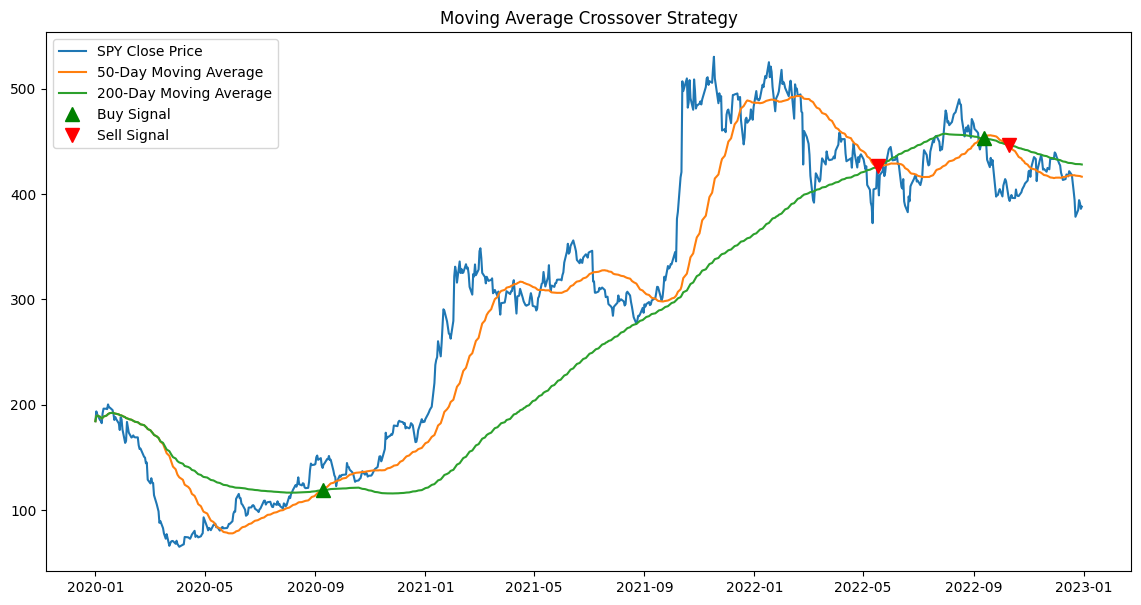

In [9]:
data = moving_average_crossover(data)

# Plot the data to visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='SPY Close Price')
plt.plot(data['Short_MA'], label='50-Day Moving Average')
plt.plot(data['Long_MA'], label='200-Day Moving Average')
plt.plot(data[data['Position'] == 1].index, data['Short_MA'][data['Position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data[data['Position'] == -1].index, data['Short_MA'][data['Position'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Moving Average Crossover Strategy')
plt.legend(loc='best')
plt.show()

In [10]:
# Backtest Strategy
initial_capital = 10000
share_size = 10  # Shares to buy

# Calculate positions
data['Holdings'] = data['Signal'] * share_size * data['Close']
data['Cash'] = initial_capital - (data['Position'] * share_size * data['Close']).cumsum()
data['Total_Asset'] = data['Cash'] + data['Holdings']

# Calculate returns
data['Returns'] = data['Total_Asset'].pct_change()

# Output the strategy's performance
final_value = data['Total_Asset'][-1]
total_return = (final_value - initial_capital) / initial_capital * 100

print(f"Final Portfolio Value: {final_value}")
print(f"Total Return: {total_return:.2f}%")

Final Portfolio Value: 12142.000122070312
Total Return: 21.42%


<ipython-input-10-3c447a054600>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_value = data['Total_Asset'][-1]


In [11]:
# Calculate Sharpe Ratio
sharpe_ratio = data['Returns'].mean() / data['Returns'].std() * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# Calculate Max Drawdown
rolling_max = data['Total_Asset'].cummax()
drawdown = data['Total_Asset'] / rolling_max - 1
max_drawdown = drawdown.min()
print(f'Max Drawdown: {max_drawdown:.2f}%')

Sharpe Ratio: 0.68
Max Drawdown: -0.13%


In [18]:
import pandas as pd

In [19]:
import yfinance as yf
import backtrader as bt

In [22]:
import pandas as pd
import yfinance as yf
import numpy as np
import backtrader as bt
from datetime import datetime

class MovingAverageCrossover(bt.Strategy):
    params = (('short_period', 50), ('long_period', 200))

    def __init__(self):
        self.short_ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.short_period)
        self.long_ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.long_period)

    def next(self):
        if not self.position:  # Not in the market
            if self.short_ma > self.long_ma:
                self.buy()
        elif self.short_ma < self.long_ma:
            self.sell()

# Initialize the backtest engine
cerebro = bt.Cerebro()
cerebro.addstrategy(MovingAverageCrossover)

# Fetch data using yfinance
# The issue was that YahooFinanceData expects a local CSV file,
# but we want to download data directly.
# Solution: Download data using yfinance and create a PandasData feed.
df = yf.download('TATAMOTORS.NS', start=datetime(2020, 1, 1), end=datetime(2023, 1, 1))
data = bt.feeds.PandasData(dataname=df)

cerebro.adddata(data)

# Set initial cash
cerebro.broker.setcash(10000)

# Run the backtest
cerebro.run()

# Plot the results
cerebro.plot()

[*********************100%***********************]  1 of 1 completed


[[<Figure size 640x480 with 4 Axes>]]